In [1]:
import numpy as np

import qcodes as qc

## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)


## Using interactive widget
from qcodes.interactive_widget import experiments_widget

In [2]:
station = qc.Station()
from qcodes.instrument_drivers.rohde_schwarz import (
    RohdeSchwarzZVA24,
    RohdeSchwarzZNBChannel,
)
vna = RohdeSchwarzZVA24("VNA", "TCPIP0::192.168.10.56::inst0::INSTR")
station.add_component(vna)

ImportError: cannot import name 'RohdeSchwarzZVA24' from 'qcodes.instrument_drivers.rohde_schwarz' (c:\Users\cluster\anaconda3\envs\qcode\Lib\site-packages\qcodes\instrument_drivers\rohde_schwarz\__init__.py)

In [3]:
from qcodes.instrument_drivers.rohde_schwarz import RohdeSchwarzSGS100A
sgsa = RohdeSchwarzSGS100A("SGSA100", "TCPIP0::192.168.10.44::inst0::INSTR")
station.add_component(sgsa)

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/114213, firmware:4.2.76.0-4.30.046.295) in 0.15s


'SGSA100'

In [4]:
station.components

{'SGSA100': <RohdeSchwarzSGS100A: SGSA100>}

In [5]:
sgsa.frequency(2.5e9)
sgsa.power(-10)
sgsa.status(True)

In [42]:
initialise_or_create_database_at("~/vnapdr.db")
qc.config.core.db_location
testexp = load_or_create_experiment(
    experiment_name="testexp", sample_name="synthetic data"
)

In [8]:
vna.channels.S21.start(0.5e9)
vna.channels.S21.stop(3e9)
vna.channels.S21.npts(101)
vna.channels.S21.power(-30)
vna.channels.S21.avg(30)
vna.channels.S21.bandwidth(10000)
vna.channels.S21.averaging_enabled(True)
vna.channels.S21.auto_sweep_time_enabled(True)
vna.timeout(600)

In [11]:
from time import time, sleep
vna.rf_on()
meas = Measurement()
meas.register_parameter(vna.channels.S21.trace)

start = time()
with meas.run() as datasaver:
    get_v = vna.channels.S21.trace.get()
    datasaver.add_result((vna.channels.S21.trace, get_v))
stop = time()
print(stop-start)

Starting experimental run with id: 46. 
6.8282694816589355


In [12]:
dataset = datasaver.dataset

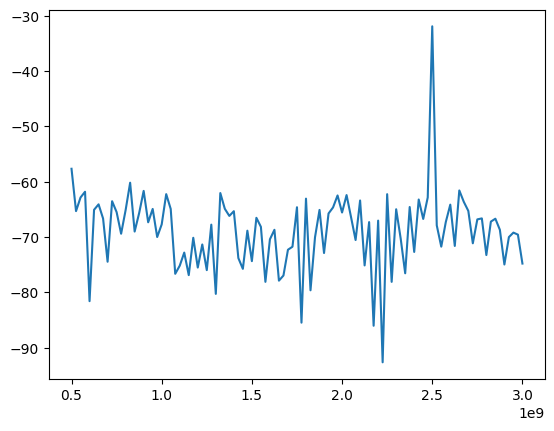

In [13]:
import matplotlib.pyplot as plt
f = dataset.get_parameter_data()
y = f['VNA_S21_trace']['VNA_S21_trace'][0]
x = f['VNA_S21_trace']['VNA_S21_S21_frequency'][0]
plt.plot(x, y)

In [10]:
# now make some silly set-up and tear-down actions


def veryfirst():
    print("Starting the measurement")


def numbertwo(inst1, inst2):
    print(f"Doing stuff with the following two instruments: {inst1}, {inst2}")


def thelast():
    print("End of experiment")

In [11]:
from time import time, sleep

meas = Measurement(exp=testexp, name="rf sweep")
meas.register_parameter(sgsa.frequency)  # register the first independent parameter
meas.register_parameter(vna.channels.S21.trace, setpoints=(sgsa.frequency,)) 
meas.add_before_run(veryfirst, ())  # add a set-up action
meas.add_before_run(numbertwo, (vna, sgsa))  # add another set-up action
meas.add_after_run(thelast, ())  # add a tear-down action

meas.write_period = 5
vna.rf_on()
sgsa.status(True)
with meas.run() as datasaver:
    for set_v in np.linspace(1e9, 2e9, 11):
        sgsa.frequency(set_v)
        # vna.write(f'SENS5:AVER:CLE')
        get_v = vna.channels.S21.trace.get()
        # while int(vna.ask(f'SENS:AVER:COUN:CURR?')) ==  vna.channels.S21.avg():
        datasaver.add_result((sgsa.frequency, set_v), (vna.channels.S21.trace, get_v))
    dataset1D = datasaver.dataset  # convenient to have for data access and plotting
sgsa.status(False)

Starting the measurement
Doing stuff with the following two instruments: <RohdeSchwarzZVA24: VNA>, <RohdeSchwarzSGS100A: SGSA100>
Starting experimental run with id: 58. 
End of experiment


In [37]:
vna.write(f'SENS5:AVER:CLE')
vna.ask(f'SENS5:AVER:COUN:CURR?')

'0\n'

In [41]:
vna.ask(f'SENS5:AVER:COUN:CURR?')

'10\n'

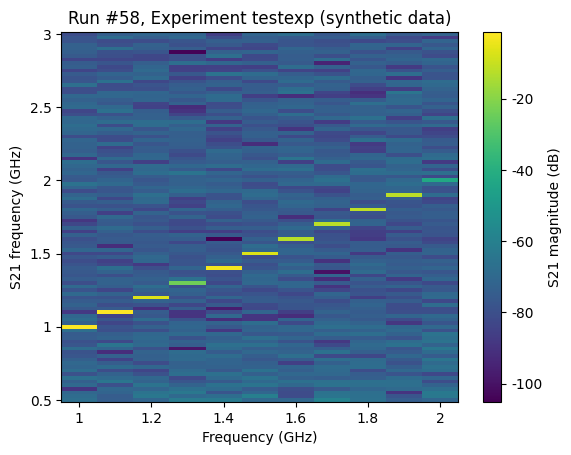

In [12]:
ax, cbax = plot_dataset(dataset1D)

In [16]:
dataset1D.export("csv", path=".")

In [12]:
from qcodes.instrument_drivers.yokogawa import YokogawaGS200
gs = YokogawaGS200(
    "gs200", address="USB::0x0B21::0x0039::91S522309::INSTR", terminator="\n"
)


Connected to: YOKOGAWA GS210 (serial:91S522309, firmware:2.02) in 0.01s


KeyError: 'Another instrument has the name: gs200'

In [15]:
gs.current_limit()
gs.current_limit(10e-3)

In [25]:
gs.output('off')

In [24]:
from time import time
start = time()
gs.ramp_current(0.05e-3, 0.001e-3, 5)
print(time()-start)
gs.ramp_current(0, 0.001, 5)

KeyboardInterrupt: 

# AWG

In [5]:
from qcodes.instrument_drivers.tektronix import TektronixAWG70002A

awg = TektronixAWG70002A("AWG1", "TCPIP0::192.168.10.171::inst0::INSTR", timeout=40)

Connected to: TEKTRONIX AWG5208 (serial:B030598, firmware:FV:6.6.0131.0) in 0.05s


In [6]:
import numpy as np
pars = np.sort(list(awg.parameters.keys()))
for param in pars:
    print(param, ": ", awg.parameters[param].label)

IDN :  IDN
all_output_off :  All Output Off
clock_external_frequency :  External clock frequency
clock_source :  Clock source
current_directory :  Current file system directory
mode :  Instrument operation mode
run_state :  Run state
sample_rate :  Clock sample rate
timeout :  timeout


In [4]:
# awg.print_readable_snapshot(update=True)

In [7]:
# set the instrument in awg mode
awg.mode("AWG")
# set the resolution to 8 bits plus two markers
awg.ch1.resolution(15)

In [8]:
awg.ch1.awg_amplitude(1)


In [9]:
awg.clearSequenceList()
awg.clearWaveformList()

In [10]:
# Let us make a sine, upload it and play it

N = 50000  # minimal length allowed is 2400 points

m1 = np.concatenate((np.ones(int(N / 2)), np.zeros(int(N / 2))))
m2 = np.concatenate((np.zeros(int(N / 2)), np.ones(int(N / 2))))
m3 = np.concatenate((np.zeros(int(N / 2)), -np.ones(int(N / 2))))
ramp = 0.075 * np.linspace(0, 1, N)

mysine = 0.1 * np.sin(10 * 2 * np.pi * np.linspace(0, 1, N)) + ramp

data = np.array([mysine, m1])

In [1]:
filename = "examplewaveform1.wfmx"
wfmx_file =awg.makeWFMXFile(data, 0.5)
awg.sendWFMXFile(wfmx_file, filename)
awg.loadWFMXFile(filename)
awg.waveformList
awg.ch2.setWaveform(filename.replace(".wfmx", ""))

NameError: name 'awg' is not defined

In [4]:
# Switch channel 1 on
awg.ch2.state(1)

# Start outputting...
awg.play()

KeyboardInterrupt: 

In [55]:
awg.stop()
awg.ch1.state(0)



In [20]:
# # Let's make a sequence where a sine plays on one channel while the other channel ramps
# # and then the roles reverse

# # As a preparation, let's set both channels to 300 mV peak-to-peak
# awg.ch1.awg_amplitude(0.3)
# awg.ch2.awg_amplitude(0.3)

# N = 20000  # minimally 2400

# SR = 1e9
# awg.sample_rate(SR)  # set the sample rate on the instrument
# ramp_target = 0.1  # ramp target (V)

# time = np.linspace(0, N / SR, N)
# sinesignal = 0.15 * np.sin(SR / N * 2 * np.pi * time)
# m1 = np.concatenate((np.ones(int(N / 2)), np.zeros(int(N / 2))))
# m2 = np.concatenate((np.zeros(int(N / 2)), np.zeros(int(N / 2))))
# rampsignal = np.linspace(0, ramp_target, N)

# # Then we compose and upload a .seqx file in 6 steps

# # Step 1: cast the waveform data into the .wfmx format
# # To make a .wfmx, we need to know the amplitude of the output channel
# ch1_amp = awg.ch1.awg_amplitude()
# ch2_amp = awg.ch2.awg_amplitude()

# # wfm_ch1_n1 = awg.makeWFMXFile(np.array([sinesignal, m1, m2]), ch1_amp)
# # wfm_ch1_n2 = awg.makeWFMXFile(np.array([rampsignal, m1, m2]), ch1_amp)
# # wfm_ch2_n1 = awg.makeWFMXFile(np.array([rampsignal, m1, m2]), ch2_amp)
# # wfm_ch2_n2 = awg.makeWFMXFile(np.array([sinesignal, m1, m2]), ch2_amp)


# wfm_ch1_n1 = np.array([sinesignal, m1, m2])
# wfm_ch1_n2 = np.array([rampsignal, m1, m2])
# wfm_ch2_n1 = np.array([rampsignal, m1, m2])
# wfm_ch2_n2 = np.array([sinesignal, m1, m2])

# # Step 2: decide on sequencing information
# # This information is provided as lists of the same length as the
# # sequence
# trig_waits = [0, 0]  # 0: off, 1: trigA, 2: trigB, 3: EXT
# nreps = [2, 3]  # 0 corresponds to infinite
# event_jumps = [0, 0]  # 0: off, 1: trigA, 2: trigB, 3: EXT
# event_jump_to = [
#     0,
#     0,
# ]  # irrelevant if event-jump is 0, else the sequence pos. to jump to
# go_to = [0, 1]  # 0 means next

# # Step 3: make the .seqx file
# # The sequence must be given a name

# seqname = "tutorial_sequence"

# wfms = [[wfm_ch1_n1, wfm_ch1_n2], [wfm_ch2_n1, wfm_ch2_n2]]

# seqx = awg.makeSEQXFile(
#     trig_waits,
#     nreps,
#     event_jumps,
#     event_jump_to,
#     go_to,
#     wfms,
#     [ch1_amp, ch2_amp],
#     seqname,
# )

# # Step 4: Transfer the seqx file
# awg.sendSEQXFile(seqx, "thursday.seqx")

# # Step 5: Load the seqx file
# awg.loadSEQXFile("thursday.seqx")
# # Now the sequence should appear in the sequencelist, but it is not yet assigned to channels

# # Step 6: Assign tracks from the sequence to the channels
# # Unlike older/other AWG models, this can be done on a per-channel basis
# awg.ch1.setSequenceTrack(seqname, 1)
# awg.ch2.setSequenceTrack(seqname, 2)

In [13]:
from qcodes.dataset import do1d, plot_by_id
from qcodes.instrument_drivers.AlazarTech import (
    AlazarTechATS9371,
    DemodulationAcquisitionController,
)
from qcodes.parameters import ManualParameter

ImportError: cannot import name 'AlazarTechATS9371' from 'qcodes.instrument_drivers.AlazarTech' (c:\Users\cluster\anaconda3\envs\qcode\Lib\site-packages\qcodes\instrument_drivers\AlazarTech\__init__.py)

In [6]:
AlazarTechATS9371.find_boards()

[{'system_id': 1,
  'board_id': 1,
  'board_kind': 'ATS9371',
  'max_samples': 4294967294,
  'bits_per_sample': 12}]

In [7]:
ats_inst = AlazarTechATS9371(name="Alazar1")
ats_inst.get_idn() 

{'firmware': '31.12',
 'model': 'ATS9371',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '860126',
 'vendor': 'AlazarTech',
 'CPLD_version': '33.9',
 'driver_version': '7.0.5',
 'SDK_version': '7.0.5',
 'latest_cal_date': '16-03-20',
 'memory_size': '4294967294',
 'asopc_type': 1545568675,
 'pcie_link_speed': '0.75GB/s',
 'pcie_link_width': '8'}

In [8]:
with ats_inst.syncing():
    ats_inst.clock_source("INTERNAL_CLOCK")
    ats_inst.sample_rate(1_000_000_000)
    ats_inst.clock_edge("CLOCK_EDGE_RISING")
    ats_inst.decimation(1)
    ats_inst.coupling1("DC")
    ats_inst.coupling2("DC")
    ats_inst.channel_range1(0.4)
    ats_inst.channel_range2(0.4)
    ats_inst.impedance1(50)
    ats_inst.impedance2(50)
    ats_inst.trigger_operation("TRIG_ENGINE_OP_J")
    ats_inst.trigger_engine1("TRIG_ENGINE_J")
    ats_inst.trigger_source1("EXTERNAL")
    ats_inst.trigger_slope1("TRIG_SLOPE_POSITIVE")
    ats_inst.trigger_level1(160)
    ats_inst.trigger_engine2("TRIG_ENGINE_K")
    ats_inst.trigger_source2("DISABLE")
    ats_inst.trigger_slope2("TRIG_SLOPE_POSITIVE")
    ats_inst.trigger_level2(128)
    ats_inst.external_trigger_coupling("DC")
    ats_inst.external_trigger_range("ETR_2V5")
    ats_inst.trigger_delay(0)
    ats_inst.aux_io_mode("AUX_IN_AUXILIARY")  # AUX_IN_TRIGGER_ENABLE for seq mode on
    ats_inst.aux_io_param("NONE")  # TRIG_SLOPE_POSITIVE for seq mode on

    # Note that we set this parameter to a non-0 value for demonstration purposes - doing so allows
    # to perform an acquisition using just the Alazar card without any additional hardware.
    # Read Alazar SDK manual about `AlazarSetTriggerTimeOut` function for more information.
    ats_inst.timeout_ticks(0)

In [10]:
acquisition_controller = DemodulationAcquisitionController(
    name="acquisition_controller", demodulation_frequency=50e6, alazar_name="Alazar1"
)

KeyError: 'Another instrument has the name: acquisition_controller'

In [12]:
acquisition_controller.demodulation_frequency=50e6

In [19]:
acquisition_controller.update_acquisitionkwargs(  # mode='NPT',
    samples_per_record=1024,
    records_per_buffer=1000,
    buffers_per_acquisition=10,
    channel_selection='AB',
    transfer_offset=0,
    external_startcapture='DISABLED',
    enable_record_headers='DISABLED',
    alloc_buffers='DISABLED',
    fifo_only_streaming='DISABLED',
    interleave_samples='DISABLED',
    get_processed_data='DISABLED',
    allocated_buffers=1,
    buffer_timeout=1000
)

In [34]:
acquisition_controller.acquisition()

np.float64(0.7501440134891704)

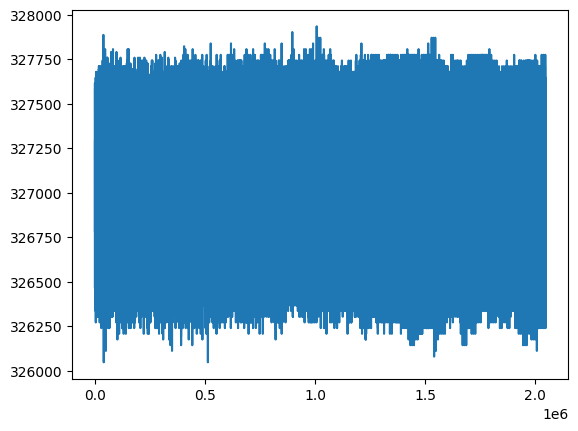

In [35]:
import matplotlib.pyplot as plt
plt.plot(acquisition_controller.buffer)

In [21]:
acquisition_controller.post_acquire()

np.float64(0.750585580563718)

In [22]:
acquisition_controller.fit(acquisition_controller.buffer[:len(acquisition_controller.buffer)//2])

ValueError: shapes (1024000,) and (1024,) not aligned: 1024000 (dim 0) != 1024 (dim 0)

In [4]:
board_handle = ats.AlazarGetBoardBySystemID(system_id, board_id)
board_handle

1388

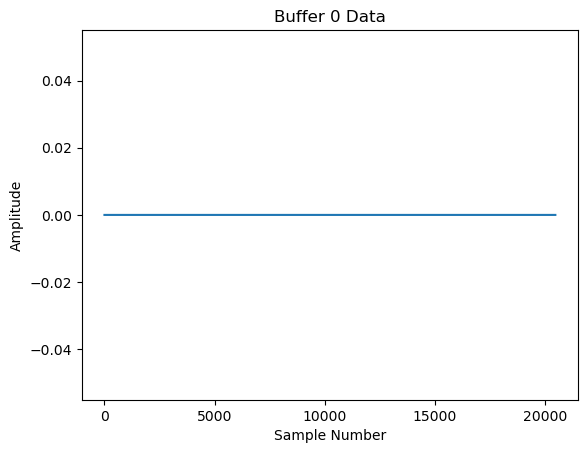

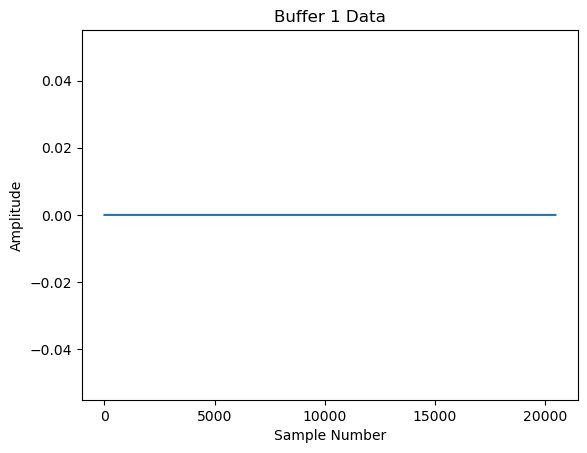

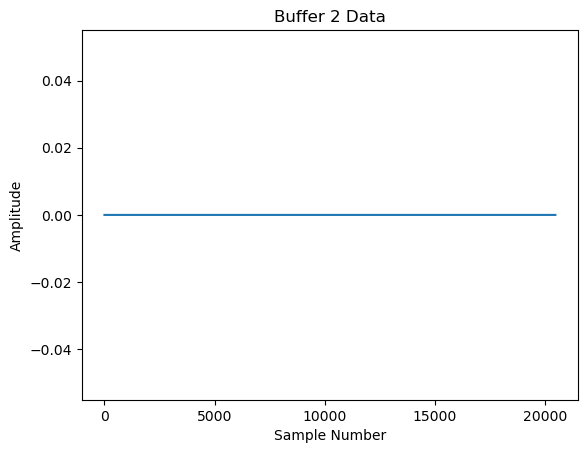

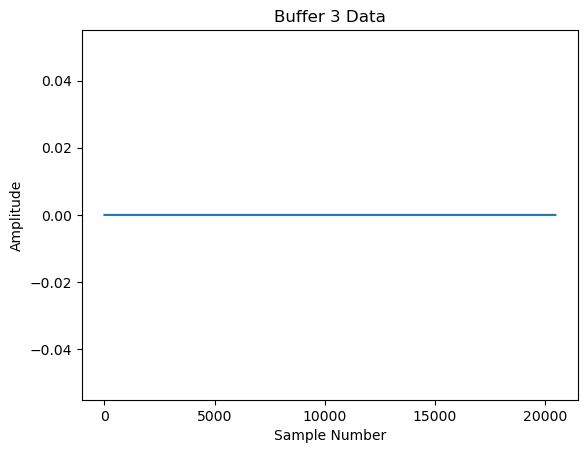

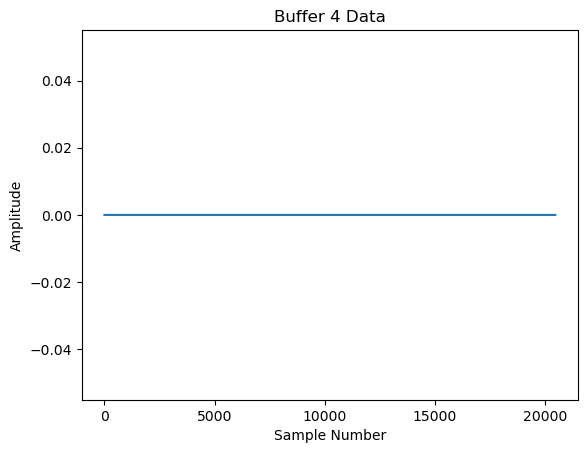

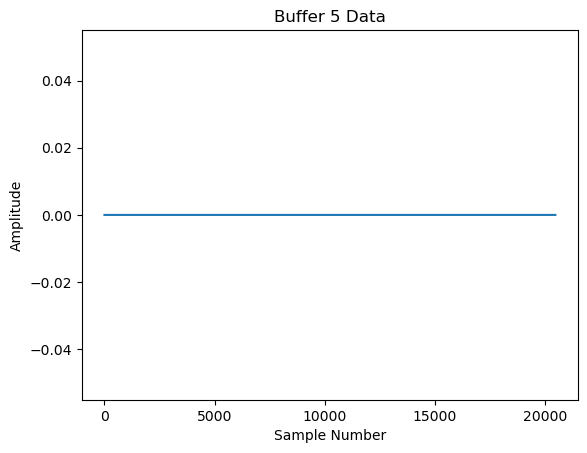

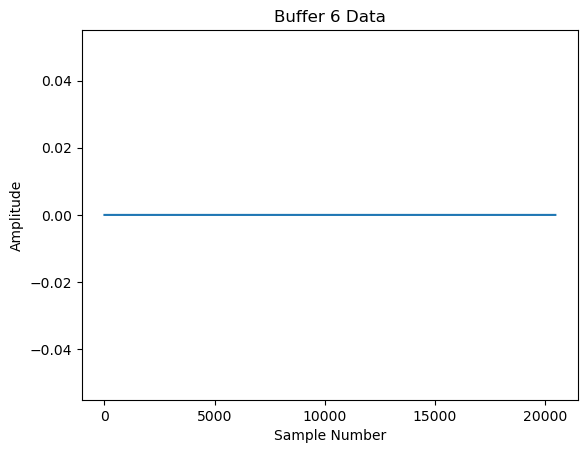

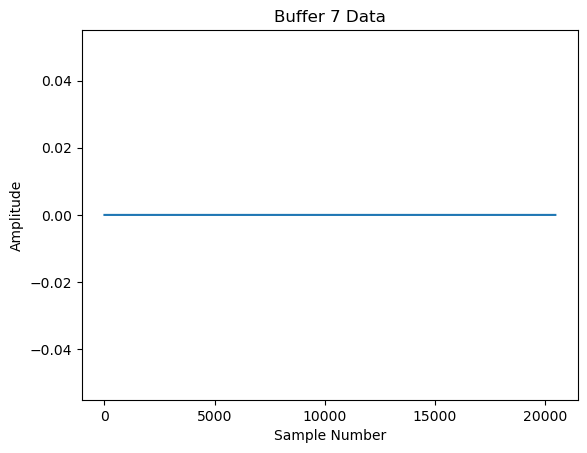

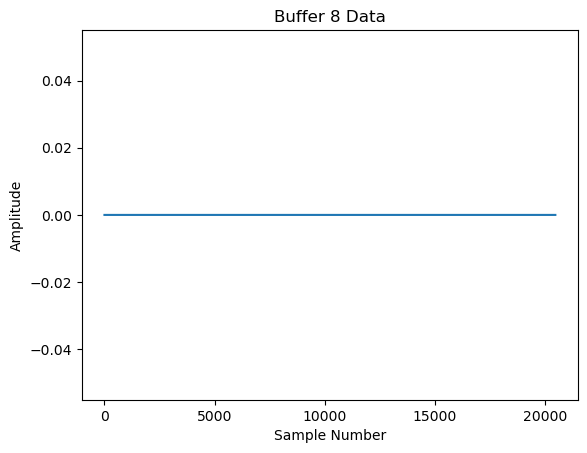

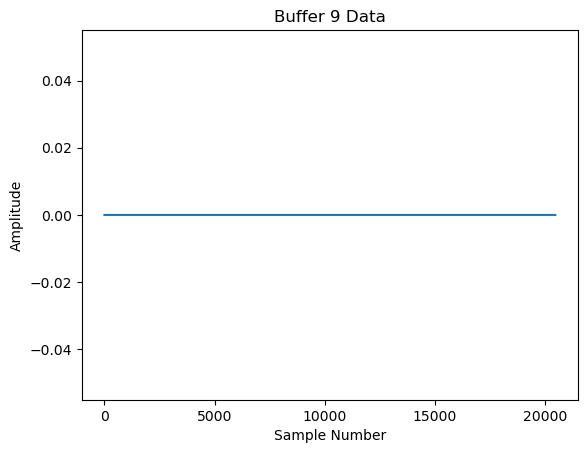

Data acquisition completed.


In [8]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt

# 此段程式碼的前半部分與前面的範例相同
# 略過設備初始化、觸發和參數設置等部分

# 開始數據採集
ats.AlazarStartCapture(board_handle)

# 分配緩衝區
buffer = np.zeros(memory_size_in_samples, dtype=np.uint16)

try:
    for buffer_index in range(buffers_per_acquisition):
        # 讀取數據至緩衝區
        ats.AlazarRead(
            board_handle,
            CHANNEL_A | CHANNEL_B,
            buffer.ctypes.data_as(ctypes.POINTER(ctypes.c_uint16)),
            samples_per_record * records_per_buffer,
            0
        )
        
        # 將數據複製到 NumPy 陣列中
        # 根據需求可以選擇不同的方式查看數據
        data_array = np.copy(buffer)

        # 繪製數據
        plt.plot(data_array)
        plt.title(f"Buffer {buffer_index} Data")
        plt.xlabel("Sample Number")
        plt.ylabel("Amplitude")
        plt.show()

finally:
    # 停止採集
    ats.AlazarAbortAsyncRead(board_handle)
    ats.AlazarClose(board_handle)
    print("Data acquisition completed.")


In [23]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

def move_line(num_frames):
    x_vals = [-1.25,.75]
    y_left_array = np.linspace(9.1, 9.7, num=num_frames, endpoint=True)
    y_right_array = np.linspace(8.0, 7.5, num=num_frames, endpoint=True)
    
    fig = plt.figure()
    red = plt.plot(x_vals, [9.7,7.5], color = 'r', label = 'right')
    blue, = plt.plot([], [], color = 'b', label = 'wrong')

    def animate(I):
        y_vals = [y_left_array[i],y_right_array[I]]
        blue.set_data(x_vals,y_vals)
        return blue,

    anim = FuncAnimation(
        fig,
        animate,
        frames = num_frames,
        interval = 1000/30,
        repeat = False,
        blit = True
    )

    plt.show()

    return anim

animate_lines = move_line(100)

<IPython.core.display.Javascript object>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 初始化 2D 陣列，假設有 100 筆資料，每筆資料長度為 50
num_measurements = 100
data_length = 50
data_2d = np.zeros((num_measurements, data_length))

# 設置即時繪圖
fig, ax = plt.subplots()
im = ax.imshow(data_2d, aspect='auto', cmap='viridis')

def update_data(new_data, i):
    # 更新 2D 陣列的第 i 行
    data_2d[i] = new_data
    
    # 更新圖像數據
    im.set_array(data_2d)
    plt.draw()
    return [im]

# 模擬資料到來，每隔 100 ms 加入新資料
def data_gen():
    for i in range(num_measurements):
        yield np.random.random(data_length), i

# 動畫函數
ani = animation.FuncAnimation(fig, lambda frame: update_data(*frame), data_gen, interval=100, blit=True)

plt.colorbar(im)
plt.show()


<IPython.core.display.Javascript object>